In [31]:
#!pip install torchinfo
#!pip install autopep8


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.0/45.0 kB 6.9 MB/s eta 0:00:00


In [38]:
from torchvision.io.image import read_image
from PIL import Image
from torchvision.models.detection import fasterrcnn_resnet50_fpn_v2, FasterRCNN_ResNet50_FPN_V2_Weights
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import torch
import urllib

##import all the libraries

import wandb
from PIL import Image
import IPython.display as display
import torch
import requests
from transformers import CLIPProcessor, CLIPModel
import matplotlib.pyplot as plt
import torch
import json
from sklearn.model_selection import train_test_split
import random
from torch.utils.data import IterableDataset, DataLoader
from ultralytics import YOLO

from tqdm import tqdm
import torchvision
from torchvision.transforms import functional as F
from torchvision import transforms
from torchinfo import summary
import urllib
import os
import torchvision.transforms as T
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np
import jsonlines
import cv2
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [39]:
## random directories that will be needed

cur_dir = os.getcwd()
vlm_dir = os.path.dirname(cur_dir)
til_dir = os.path.dirname(vlm_dir)
home_dir = os.path.dirname(til_dir)
test_dir = os.path.join(home_dir, 'novice')
img_dir = os.path.join(test_dir, 'images')
data_dir = os.path.join(cur_dir, 'data')

##training data to be added to tune the models
metadata_path = os.path.join(test_dir, 'vlm.jsonl')

output_dir = os.path.join(data_dir,"imgs")

print(output_dir)

/home/jupyter/til-24-base/vlm/src/data/imgs


## <span style="color:blue;">Prepare the data set merge the image and captions together</span>

In [7]:
class MemmapImageDataset(IterableDataset):
    def __init__(self, img_dir, num_batches):
        self.img_dir = img_dir
        self.num_batches = num_batches

    def __iter__(self):
        for batch_idx in range(self.num_batches):
            batch_path = os.path.join(self.img_dir, f"batch_{batch_idx}")

            image_batch_memmap_path = os.path.join(batch_path, "image_batch.npy")
            image_batch = np.load(image_batch_memmap_path, mmap_mode='r')
            image_batch = torch.tensor(image_batch)

            yield image_batch


# def split_data(data, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, seed=42):
#     random.seed(seed)

#     total_examples = len(data['image'])
#     indices = list(range(total_examples))
#     random.shuffle(indices)
    
#     train_end = int(train_ratio * total_examples)
#     val_end = train_end + int(val_ratio * total_examples)
    
#     train_indices = indices[:train_end]
#     val_indices = indices[train_end:val_end]
#     test_indices = indices[val_end:]
    
#     train_data = {'image': [data['image'][i] for i in train_indices]}
#     val_data = {'image': [data['image'][i] for i in val_indices]}
#     test_data = {'image': [data['image'][i] for i in test_indices]}
    
#     return train_data, val_data, test_data

# MAX_FILE_COUNT = None  # Set if only want max files
# data = {'image': []}
# data_path = os.path.join(test_dir, "vlm.jsonl")
# with jsonlines.open(metadata_path) as reader:
#     for obj in reader:
#         if MAX_FILE_COUNT and len(data['image']) >= MAX_FILE_COUNT:
#             break
#         data['image'].append(os.path.join(img_dir, obj['image']))

# train_data, val_data, test_data = split_data(data)

In [14]:
# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)


# Step 2: Load data from a file directory
image_files = os.listdir(img_dir)

# # List to store loaded images
# images = []

# # Loop through each image file in the directory
# for file in image_files:
#     # Construct the full path to the image file
#     file_path = os.path.join(img_dir, file)
    
#     # Open the image file using PIL
#     image = Image.open(file_path)
    
#     # Append the loaded image to the list
#     images.append(image)

# # Now, 'images' contains all the loaded images from the directory

# Step 3: Apply preprocessing transforms
preprocess = weights.transforms()




In [15]:
def preprocess_and_save_batches(dataset, output_dir, batch_size=64, device="cuda"):
    images = dataset['image']
    num_batches = (len(images) + batch_size - 1) // batch_size

    for batch_idx in tqdm(range(num_batches), desc="Processing Batches"):
        batch_images = images[batch_idx * batch_size:(batch_idx + 1) * batch_size]
        
        image_array = []

        for image_path in batch_images:
            # Load image
            image = cv2.imread(image_path)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

            if image is None or image.shape[0] == 0 or image.shape[1] == 0:
                print(f"Skipping invalid image: {image_path}")
                continue

            # Convert to PIL Image for preprocessing
            pil_image = Image.fromarray(image)

            # Apply preprocessing transforms
            preprocessed_image = preprocess(pil_image)

            # Convert to numpy array
            image = np.array(preprocessed_image)

            # Append preprocessed image tensor to list
            image_array.append(image)

        if len(image_array) < batch_size:
            print(f"Padding batch {batch_idx} with dummy data to reach target batch size of {batch_size}")
        while len(image_array) < batch_size:
            dummy_image = torch.zeros_like(image_array[0])
            image_array.append(dummy_image)
            
        image_batch = np.stack(image_array)

        image_memmap_path = os.path.join(output_dir, f"image_batch_{batch_idx}.npy")
        np.save(image_memmap_path, image_batch)

    return num_batches

In [16]:
# os.makedirs(data_dir, exist_ok=True)
# train_num_batches = preprocess_and_save_batches(train_data, train_dir)
# val_num_batches = preprocess_and_save_batches(val_data, val_dir)
test_num_batches = preprocess_and_save_batches(test_data, test_dir)

Processing Batches:  88%|████████▊ | 7/8 [01:42<00:14, 14.60s/it]

Padding batch 7 with dummy data to reach target batch size of 64


NameError: name 'image_tensors' is not defined

In [27]:
print(f"Number of batches for train: {train_num_batches}")
print(f"Number of batches for val: {val_num_batches}")
print(f"Number of batches for test: {test_num_batches}")

train_num_batches = 63
val_num_batches = 8
test_num_batches = 8

Number of batches for train: 63
Number of batches for val: 8
Number of batches for test: 8


The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.


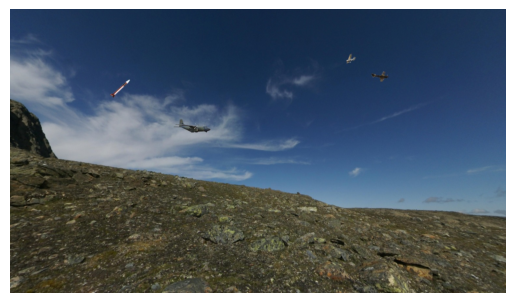

In [33]:
# # Load the first batch of preprocessed images
# batch_idx = 0  # Assuming you want to visualize the first batch
# batch_output_dir = os.path.join(train_dir, f"batch_{batch_idx}")
# image_batch_memmap_path = os.path.join(batch_output_dir, "image_batch.npy")
# image_batch = np.load(image_batch_memmap_path)

# # Assuming first_image_tensor is a PyTorch tensor
# first_image_tensor = torch.Tensor(image_batch[0])

# # Convert the PyTorch tensor to a NumPy array and then permute the dimensions
# first_image_np = first_image_tensor.permute(1, 2, 0).numpy()

# # Visualize the first image tensor
# plt.imshow(first_image_np)
# plt.axis('off')
# plt.show()


In [27]:
# Step 1: Initialize model with the best available weights
weights = FasterRCNN_ResNet50_FPN_V2_Weights.DEFAULT
model = fasterrcnn_resnet50_fpn_v2(weights=weights, box_score_thresh=0.9)

preprocess = weights.transforms()

In [28]:
def preprocess_and_save_images_from_directory(input_dir, output_dir):
    image_files = [file for file in os.listdir(input_dir) if file.endswith('.jpg') or file.endswith('.png')]

    for filename in tqdm(image_files, desc="Processing Images"):
        # Load image
        image_path = os.path.join(input_dir, filename)
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        if image is None or image.shape[0] == 0 or image.shape[1] == 0:
            print(f"Skipping invalid image: {image_path}")
            continue

        # Convert to PIL Image for preprocessing
        pil_image = Image.fromarray(image)

        # Apply preprocessing transforms
        preprocessed_image = preprocess(pil_image)

        # Convert to numpy array
        image_array = np.array(preprocessed_image)

        # Save preprocessed image
        output_path = os.path.join(output_dir, filename + ".npy")
        np.save(output_path, image_array)

    print(f"Preprocessing and saving complete. {len(image_files)} images processed.")

In [ ]:
os.makedirs(output_dir, exist_ok=True)

preprocess_and_save_images_from_directory(img_dir, output_dir)

Processing Images:  43%|████▎     | 2230/5234 [10:02<15:12,  3.29it/s]

Height: 870
Width: 1520
Channels: 3


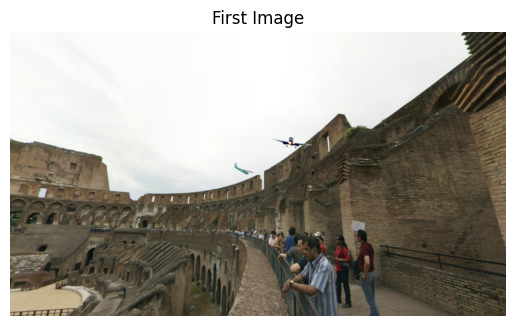

In [44]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the filename of the .npy file containing the image
filename = "image_0.jpg.npy"  # Replace with the actual filename

# Construct the full path to the .npy file
image_path = os.path.join(output_dir, filename)

# Load the image
image_array = np.load(image_path)

# Transpose the dimensions to have channels as the last dimension
image_array = np.transpose(image_array, (1, 2, 0))

# Get the dimensions
height, width, channels = image_array.shape
print("Height:", height)
print("Width:", width)
print("Channels:", channels)

# Visualize the image
plt.imshow(image_array)
plt.title("First Image")
plt.axis('off')
plt.show()


Height: 870
Width: 1520
Channels: 3


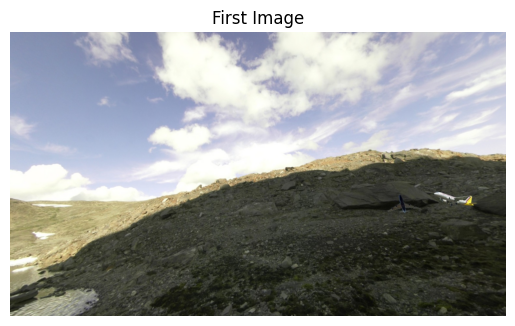

In [45]:
import os
import numpy as np
import matplotlib.pyplot as plt

# Define the filename of the .npy file containing the image
filename = "image_1.jpg.npy"  # Replace with the actual filename

# Construct the full path to the .npy file
image_path = os.path.join(output_dir, filename)

# Load the image
image_array = np.load(image_path)

# Transpose the dimensions to have channels as the last dimension
image_array = np.transpose(image_array, (1, 2, 0))

# Get the dimensions
height, width, channels = image_array.shape
print("Height:", height)
print("Width:", width)
print("Channels:", channels)

# Visualize the image
plt.imshow(image_array)
plt.title("First Image")
plt.axis('off')
plt.show()
